## Business Understanding

This project aims to solve the problem of automatically classifying musical chords as either major or minor using audio input. Chord identification is a key task in music analysis, and automating it can save time on transcription and harmonic analysis. By using machine learning and music information retrieval (MIR) techniques, the goal is to create a tool that helps musicians, producers, and educators analyze music in real-time. The project focuses on making chord recognition more accessible and efficient, benefiting both students and professionals in the music industry.

---

## Tools/Methodologies

To handle the workflow, I'll use several Python libraries:

- [librosa](https://librosa.org/doc/latest/index.html) for extracting audio features, [numpy](https://numpy.org/doc/1.24/reference/index.html#reference) and [pandas](https://pandas.pydata.org/docs/reference/index.html#api) for data manipulation, and os and [Kaggle CLI](https://www.kaggle.com/code/donkeys/kaggle-python-api) to download the data directly into the notebook.
- [matplotlib](https://matplotlib.org/stable/api/index.html) and [seaborn](https://seaborn.pydata.org/api.html) for exploring and visualizing features like waveforms and spectrograms.
- [scikit-learn](https://scikit-learn.org/stable/api/index.html) for baseline models (e.g., logistic regression, SVM), and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) or [keras](https://keras.io/api/) for building CNNs.

In [196]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
import json
import os

# Audio feature extraction
import librosa
from scipy.signal import find_peaks

# for Kaggle CLI
from kaggle.api.kaggle_api_extended import KaggleApi

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Deep learning for CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

## Data Understanding
The dataset used in this project is sourced from the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset on Kaggle. It contains audio files `.wav` format of chords played on two instruments: guitar and piano. The raw data has been scraped from various sources and is already available for download on Kaggle, eliminating the need for manual data collection. The dataset is well-suited for this project, as it provides a clear distinction between major and minor chords, which is the focus of the classification task.

The features for the model will be extracted from the audio files using techniques such as Mel-frequency cepstral coefficients (MFCCs) or spectrograms, which capture important frequency and temporal information from the audio signals. Although other individuals may have used this dataset for similar chord classification tasks, this project will build upon existing work by focusing specifically on distinguishing between major and minor chords, potentially improving upon current models or exploring new machine learning techniques for this type of classification.

In [133]:
# uncomment if replicating project
# !pip install kaggle

In [134]:
# Load kaggle.json credentials
api_config_path = os.path.join(os.getcwd(), 'kaggle.json')
with open(api_config_path, 'r') as f:
    kaggle_config = json.load(f)

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Ensure the 'dataset' folder exists
dataset_dir = os.path.join(os.getcwd(), 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

# Use the Kaggle API to download the dataset
api.dataset_download_files('deepcontractor/musical-instrument-chord-classification',
                           path=dataset_dir, unzip=True)

print("Dataset downloaded and extracted to:", dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset


In [135]:
# Define the base directory where the audio files are stored
base_dir = os.path.join(os.getcwd(), 'dataset', 'Audio_Files')

# Prepare to collect file details
file_details = []

# Loop through each category directory ('Major' and 'Minor')
for category in ['Major', 'Minor']:
    category_dir = os.path.join(base_dir, category)
    
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            # Full path to file
            file_path = os.path.join(category_dir, filename)
            # Append the file path, filename (used as ID), and label to the list
            file_details.append({'path': file_path, 'id': filename, 'label': category})

# Save collected file details as a DataFrame
file_data = pd.DataFrame(file_details)

file_data.head()

,path,id,label
0,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_0.wav,Major
1,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_1.wav,Major
2,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_10.wav,Major
3,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_100.wav,Major
4,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_101.wav,Major


## Music and Math

Each musical note corresponds to a fundamental frequency - the lowest frequency of a note that is musically pleasing. This frequency is what characterizes the note, which is represented by letters ['A', 'B', 'C', 'D', 'E', 'F', 'G']. 

#### Frequency:

The frequency \( f \) of a note can be calculated with the following formula:

$$ f = f_0 \times 2^{\frac{n}{12}} $$

Where:
- `f_0` is the frequency of a reference note (usually the note **A4**, which is **440 Hz**).
- `n` is the number of half-steps away from the reference note. Positive values of `n` indicate higher notes, while negative values indicate lower notes.

The standard practice in determining the closest note to a given frequency generally involves finding which standard note frequency it's nearest to.

#### Harmonics

A single note played on an instrument does not produce just one frequency. For example, playing an 'A' at 220 Hz will generate additional frequencies at 440 Hz, 660 Hz, 880 Hz, 1100 Hz, and so on. According to this [Music Note Frequency Chart](https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/) the frequencies 220, 440, and 880 Hz correspond to the musical notes A3, A4, and A5, respectively. These notes are all 'A' notes, each one octave apart. The lowest harmonic, known as the fundamental frequency, determines the perceived pitch of the sound.

> In standard musical pitch, A4, or the fourth octave 'A', is tuned to 440 Hz.

Interestingly, the frequency 1100 Hz falls between the frequencies for B5 (987.77 Hz) and C6 (1046.50 Hz). Calculating the midpoint between these two frequencies gives:

$$
\text{Midpoint} = \frac{987.77 \, \text{Hz} + 1046.50 \, \text{Hz}}{2} = 1017.135 \, \text{Hz}
$$

Since 1100 Hz is closer to 1046.50 Hz than to 987.77 Hz, it would be classified closer to C6 in standard musical pitch, though it is somewhat sharper than a typical B5. This illustrates how harmonics work in physical instruments, where playing a fundamental note also produces these higher frequencies, contributing to the richness of the instrument's sound.

#### Chords

A chord represents a combination of several notes played simultaneously, resulting in a harmonious sound. This harmony is achieved through the specific relationship of the frequencies of the notes within the chord. For instance, a simple major chord is composed of the root note, a major third above the root, and a perfect fifth above the root, creating a full and bright sound typically associated with major chords.

Minor chords, on the other hand, are formed by the root note, a minor third above the root, and a perfect fifth above the root, delivering a more melancholic or somber tone compared to major chords.

In addition to major and minor chords, two other common types are diminished and augmented chords. A diminished chord is made up of the root note, a minor third, and a diminished fifth, giving it a tense and unstable sound. An augmented chord consists of the root note, a major third, and an augmented fifth, which creates a sense of suspense or unresolved tension.

#### FourierTransforms

A Fourier transform is a powerful mathematical tool that transforms a signal from its original domain (often time or space) into a frequency domain. This transformation allows us to dissect complex signals and understand how different frequencies contribute to the overall signal. Essentially, it breaks down a wave-like signal into its individual components, highlighting the frequencies that are present.

Why does this help us? Well, by using a Fourier transform, we can analyze various aspects of signals that are not immediately apparent in the time domain. For example, in music production, it helps us identify the specific frequencies that make up a sound, which is crucial for tasks like mixing, mastering, or even sound design. This analysis provides insights into the pitch, tone, and timbre of sounds, helping audio engineers and musicians make informed decisions to enhance musical pieces.

In essence, the Fourier transform is a bridge between the time domain and the frequency domain, providing a comprehensive look at the frequencies that influence a signal. This capability makes it an indispensable tool in fields ranging from audio processing to telecommunications and beyond.

Using a frequency chart to analyze these chords would reveal a complex spectrum due to the concurrent presence of multiple notes. Each note in a chord contributes its fundamental frequency along with its harmonics, leading to a dense array of spikes on the chart. This complex interplay of frequencies helps to understand why chords have their distinctive sounds and emotional impacts.

### Spectogram

A **spectrogram** is a visual representation of the spectrum of frequencies in a sound or other signal as they vary with time. It's essentially a graph that shows the intensity (or loudness) of various frequencies over a period of time. The horizontal axis of a spectrogram represents time, the vertical axis represents frequency, and the colors or shades on the graph indicate the amplitude or strength of the frequencies at any given time. 

#### Why are they useful?

- **Analysis of Sounds**: Spectrograms are incredibly useful for analyzing the characteristics of different sounds, making them indispensable in fields like music production, linguistics, and sound engineering. They help identify variations in frequency that occur over time, which can be crucial for understanding speech patterns, musical notes, and environmental sounds.
- **Signal Processing**: In signal processing, spectrograms provide a clear visualization of how frequencies change, aiding in the enhancement or isolation of specific sounds within a mixed signal.
- **Troubleshooting**: They are also used to diagnose issues in machinery or systems by detecting unusual frequency patterns, which often indicate malfunctions.

In [136]:
from IPython.display import Audio

# To visualize audio data
from scipy.fft import fft
from scipy.io import wavfile

In [137]:
class AudioAnalyzer:
    def __init__(self, df):
        self.df = df

    def play_audio(self, file_id):
        row = self.df.iloc[file_id]
        filename = row['path']
        return Audio(filename)

    def plot_audio(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        
        # Read the audio file
        samplerate, data = wavfile.read(filename)
        times = np.arange(len(data)) / float(samplerate)
        
        # Plot time domain data
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.title("Time Domain")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.plot(times, data)
        
        # Compute and plot frequency domain data
        fft_data = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(fft_data), 1/samplerate)
        magnitude = np.abs(fft_data)[:len(data)//2]
        freqs = freqs[:len(data)//2]
        
        plt.subplot(1, 2, 2)
        plt.title("Frequency Domain")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude")
        if max_freq is not None:
            plt.xlim([0, max_freq])
        plt.plot(freqs, magnitude)
        plt.show()
        
    def plot_spectrogram(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)  # Load with the original sample rate

        # Generate the spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)

        # Plotting the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        if max_freq is not None:
            plt.ylim([0, max_freq])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency (Hz)')
        plt.tight_layout()
        plt.show()

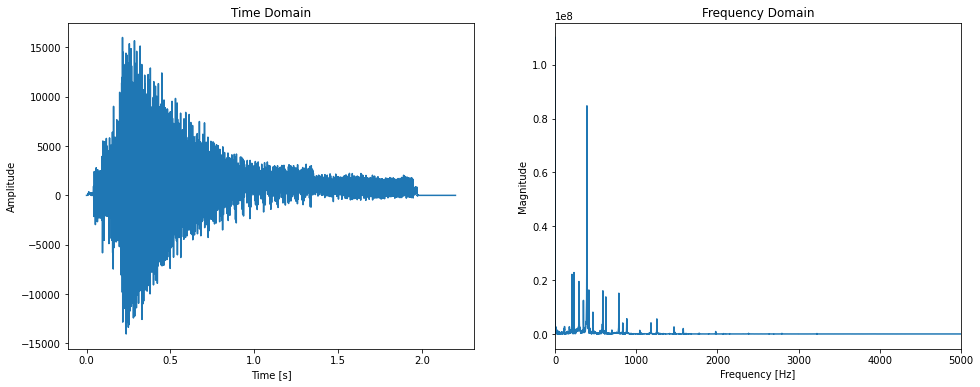

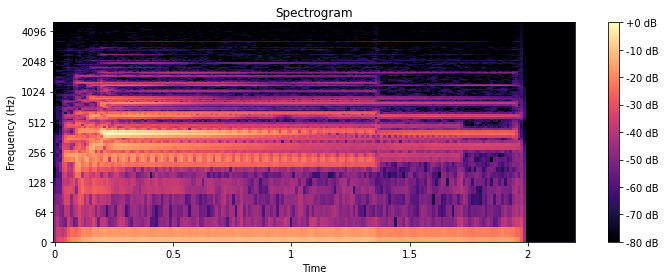

In [138]:
analyzer = AudioAnalyzer(file_data)
file_id = 440 #up to 858

# Play the audio
audio_player = analyzer.play_audio(file_id)
audio_player

# Plot the audio
analyzer.plot_audio(file_id, max_freq=5000)
analyzer.plot_spectrogram(file_id, max_freq=5000)

### Model Iterations:

#### Model v1:

First, I wanted to to compare the extract_features method I used in my [last project]() (mostly out of curiosity :p)

This included extracting features like:
- **Chroma Features**: calculated using the short-time Fourier transform (STFT) of the audio file. Chroma features capture the essence of the pitch content within each octave group - which is vital for chord identification.
- **MFCCs**: used to capture the timbral aspects of an audio signal. (This is what makes a song or chord 'feel' a certain way!) The first few coefficients especially provide a good representation of the overall spectral shape which is influenced by the harmonic structure of the chord.

These features were fed into a Convolutional Neural Network (CNN):

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| Major | 0.53      | 1.00   | 0.70     | 46      |
| Minor | 0.00      | 0.00   | 0.00     | 40      |
| **accuracy** | | | 0.53 | 86 |
| **macro avg** | 0.27 | 0.50 | 0.35 | 86 |
| **weighted avg** | 0.29 | 0.53 | 0.37 | 86 |

This is alarming - our scores for precision, recall, and f1-score for the Minor class are ALL zero. 
This is probably because we are focusing in on timbral aspects of the audio, rather than the individual frequencies of the notes in the chords. But an interesting first model!


#### Model v2:

After implementing a new feature extraction method to (instead) extract harmonics, these are the results of a simple Logistic Regression as a baseline classifier.

Accuracy: 60.47%

Classification Report (Harmonics & Simple Logistic Regression):

|               | precision | recall | f1-score | support |
|---------------|------------|--------|----------|---------|
| **Major**     | 0.63       | 0.81   | 0.71     | 101     |
| **Minor**     | 0.54       | 0.31   | 0.39     | 71      |
| **accuracy**  |            |        | 0.60     | 172     |
| **macro avg** | 0.58       | 0.56   | 0.55     | 172     |
| **weighted avg** | 0.59    | 0.60   | 0.58     | 172     |

Confusion Matrix:

[[82 19]

 [49 22]]
 
 
  Lets try a more advanced models:
 
 #### Model v3:
 
Support Vector Machine (SVM): 58.14%
              precision    recall  f1-score   support

       Major       0.60      0.83      0.70       101
       Minor       0.48      0.23      0.31        71

    accuracy                           0.58       172
   macro avg       0.54      0.53      0.50       172
weighted avg       0.56      0.58      0.54       172

[[84 17]

 [55 16]]

#### Model v4:

Random Forest Accuracy: 69.19%
              precision    recall  f1-score   support

       Major       0.76      0.70      0.73       101
       Minor       0.62      0.68      0.64        71

    accuracy                           0.69       172
   macro avg       0.69      0.69      0.69       172
weighted avg       0.70      0.69      0.69       172

[[71 30]

 [23 48]]
 
 
#### Model v5:

Neural Network Accuracy: 62.79%
              precision    recall  f1-score   support

       Major       0.63      0.89      0.74       101
       Minor       0.62      0.25      0.36        71

    accuracy                           0.63       172
   macro avg       0.63      0.57      0.55       172
weighted avg       0.63      0.63      0.58       172

Confusion Matrix for Neural Network:

[[90 11]

 [53 18]]
 
#### Model v6:

Now, using feature engineering to only train with features that will be useful for the model!

Random Tree (with feature engineering):
              precision    recall  f1-score   support

       Major       0.82      0.91      0.86        98
       Minor       0.86      0.73      0.79        74

    accuracy                           0.83       172
   macro avg       0.84      0.82      0.82       172
weighted avg       0.83      0.83      0.83       172

Confusion Matrix:

[[89  9]

[20 54]]


#### Model v7:

A lot of audio classification will rely on the MFCCS ( explain later lol ), so I also wanted to attempt combining my original model's method of extracting features with the previous model's feature engineering of the harmonics method. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.74      0.92      0.82        98
       Minor       0.84      0.58      0.69        74

    accuracy                           0.77       172
   macro avg       0.79      0.75      0.75       172
weighted avg       0.79      0.77      0.76       172

Confusion Matrix:
[[90  8]
 [31 43]]


#### Model v8:

Neural Network for the same group of features. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.71      0.82      0.76        98
       Minor       0.69      0.55      0.62        74

    accuracy                           0.70       172
   macro avg       0.70      0.69      0.69       172
weighted avg       0.70      0.70      0.70       172

Confusion Matrix:
[[80 18]
 [33 41]]

---

## Data Preparation

The dataset consists of raw .wav files, so no traditional tabular data is available. Preprocessing will involve extracting features like MFCCs, spectrograms, or chroma features to transform the audio into usable data. Challenges include ensuring that these features correctly capture the harmonic information while handling variations in recording quality and instrument type. We estimate several hundred rows of data, each representing an individual chord sample. Visualizations like waveform plots and spectrograms will be used to explore the features that distinguish major from minor chords.

### Extract Features

#### Audio features:

Using the `extract_audio_features` method, we will extract:
- mfccs and such bla bla bla

We will also normalize the data in this step.

Just like we did in our first model.

#### Harmonics and Intervals

Using the find_harmonics and selected features from our [Feature Engineering] section

#### Encode Labels
Our target feature 'label' should be converted into a numerical format.
> 0: Major 
> 1: Minor

In [170]:
def extract_audio_features(file_path, sr=22050, hop_length=512, n_fft=2048):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=sr)
        
        # Extract features with default fallback values if extraction fails
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft).mean(axis=1) \
            if len(y) > 0 else np.full(12, np.nan)  # 12 chroma features
        
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length, n_fft=n_fft).mean(axis=1) \
            if len(y) > 0 else np.full(20, np.nan)  # 20 MFCCs
        
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length).mean() \
            if len(y) > 0 else np.nan
        
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length).mean() \
            if len(y) > 0 else np.nan
        
        # Return a dictionary with the features
        return {
            'chroma': chroma,
            'mfcc': mfccs,
            'spectral_centroid': spectral_centroid,
            'zero_crossing_rate': zero_crossing_rate
        }
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

In [171]:
feature_data = []

# Extract features for each file and store them in a list
for index, row in file_data.iterrows():
    features = extract_audio_features(row['path'])
    
    if features is not None:
        feature_data.append({
            'id': row['id'].replace('.wav', ''),
            'Label': row['label'],
            'chroma': features['chroma'],  # Store chroma features
            'mfcc': features['mfcc'],      # Store MFCC features
            'spectral_centroid': features['spectral_centroid'],  # Store spectral centroid
            'zero_crossing_rate': features['zero_crossing_rate'] # Store zero-crossing rate
        })

# Prepare a list to hold each row's dictionary
feature_dict_list = []

# Determine the number of chroma and MFCC coefficients (12 chroma, 20 MFCCs)
n_chroma = 12
n_mfcc = 20

# Processing each item's features to create a flat dictionary
for item in feature_data:
    feature_dict = {
        'id': item['id'],
        'Label': item['Label']
    }
    
    # Store chroma features
    for i in range(n_chroma):
        feature_dict[f'chroma_{i+1}'] = item['chroma'][i] if i < len(item['chroma']) else np.nan
    
    # Store MFCC features
    for i in range(n_mfcc):
        feature_dict[f'mfcc_{i+1}'] = item['mfcc'][i] if i < len(item['mfcc']) else np.nan
    
    # Store spectral centroid and zero-crossing rate as scalar features
    feature_dict['spectral_centroid'] = item['spectral_centroid']
    feature_dict['zero_crossing_rate'] = item['zero_crossing_rate']
    
    feature_dict_list.append(feature_dict)

# Create a new DataFrame from the list of dictionaries
features_df = pd.DataFrame(feature_dict_list)

# Display the first few rows of the new DataFrame to verify
print(features_df.head())

          id  Label  chroma_1  chroma_2  chroma_3  chroma_4  chroma_5  \
0    Major_0  Major  0.742913  0.204407  0.173953  0.280547  0.802854   
1    Major_1  Major  0.729958  0.307365  0.092075  0.152823  0.467690   
2   Major_10  Major  0.383773  0.197410  0.057362  0.069614  0.227125   
3  Major_100  Major  0.223433  0.931608  0.578779  0.638870  0.234647   
4  Major_101  Major  0.137541  0.349761  0.289738  0.445542  0.294066   

   chroma_6  chroma_7  chroma_8  ...   mfcc_13    mfcc_14    mfcc_15  \
0  0.172853  0.121578  0.434359  ... -1.233236   2.531613  -9.903286   
1  0.221199  0.145914  0.392128  ... -5.643203  -4.957089  -3.354305   
2  0.297883  0.736757  0.224346  ... -2.584889 -16.698959 -21.908617   
3  0.322008  0.154993  0.370598  ... -7.823734  -6.011680 -10.768335   
4  0.478135  0.327209  0.586636  ...  3.361689   0.215648  -6.416312   

     mfcc_16    mfcc_17    mfcc_18    mfcc_19   mfcc_20  spectral_centroid  \
0 -18.900269 -12.511242 -15.546177 -21.641695 -6.9

In [145]:
def find_harmonics(file_path, sr=22050, n_fft=2048):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=sr)

        # Perform Fourier Transform to get the frequency spectrum
        fft_result = np.fft.fft(y)
        magnitude = np.abs(fft_result)  # Magnitude of the Fourier Transform
        frequency = np.fft.fftfreq(len(magnitude), 1/sr)  # Frequency bins

        # Only keep the positive frequencies
        positive_freq_idxs = np.where(frequency >= 0)
        positive_freqs = frequency[positive_freq_idxs]
        positive_magnitude = magnitude[positive_freq_idxs]

        # Find peaks in the frequency spectrum (harmonics)
        peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude) * 0.1)  # threshold at 10% of the max

        # Get the corresponding frequencies of the peaks (harmonic frequencies)
        harmonic_frequencies = positive_freqs[peaks]

        # Calculate intervals between harmonic frequencies
        harmonic_intervals = np.diff(harmonic_frequencies)  # Differences between successive harmonics

        # Return both harmonic frequencies and intervals
        return harmonic_frequencies, harmonic_intervals
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

In [149]:
harmonics_data = []

# Extracting harmonics for each file and storing them in a list
for index, row in file_data.iterrows():
    harmonic_frequencies, harmonic_intervals = find_harmonics(row['path'])
    
    if harmonic_frequencies is not None:
        harmonics_data.append({
            'id': row['id'].replace('.wav', ''),
            'Label': row['label'],
            'harmonics': harmonic_frequencies,  # Store harmonic frequencies
            'intervals': harmonic_intervals     # Store intervals separately
        })

# Find the maximum number of harmonic frequencies across all files
max_harmonics = max(len(item['harmonics']) for item in harmonics_data)

# Prepare a list to hold each row's dictionary
harmonics_dict_list = []

for item in harmonics_data:
    harmonic_dict = {
        'id': item['id'],
        'Label': item['Label']
    }
    
    # Fill harmonic frequencies, and pad with NaN if there are fewer than max_harmonics
    for i in range(max_harmonics):
        harmonic_dict[f'harmonic_{i+1}'] = item['harmonics'][i] if i < len(item['harmonics']) else np.nan
    
    # Optionally, add intervals if you want them as well
    if item['intervals'] is not None:
        for i in range(len(item['intervals'])):
            harmonic_dict[f'interval_{i+1}'] = item['intervals'][i]
    
    harmonics_dict_list.append(harmonic_dict)

# Create a new DataFrame from the list of dictionaries
harmonics_df = pd.DataFrame(harmonics_dict_list)

# Display the first few rows of the new DataFrame to verify
print(harmonics_df.head())

          id  Label  harmonic_1  harmonic_2  harmonic_3  harmonic_4  \
0    Major_0  Major  130.665350  165.331667  195.998025  262.219580   
1    Major_1  Major  165.331667  196.442465  261.775140  329.774454   
2   Major_10  Major  130.909091  185.000000  234.090909  262.272727   
3  Major_100  Major  155.454545  195.909091  278.181818  311.363636   
4  Major_101  Major  155.909091  196.818182  197.727273  278.181818   

   harmonic_5  harmonic_6  harmonic_7  harmonic_8  ...  interval_23  \
0  329.330014  330.218894  391.996049  392.884929  ...          NaN   
1  331.107774  392.440489  495.995001  523.994719  ...          NaN   
2  329.545455  370.454545  393.181818  468.181818  ...          NaN   
3  349.545455  392.272727  466.818182  556.363636  ...          NaN   
4  311.363636  350.454545  392.727273  466.818182  ...          NaN   

   interval_24  interval_25  interval_26  interval_27  interval_28  \
0          NaN          NaN          NaN          NaN          NaN   
1     

---

## Feature Engineering

Our first couple model iterations used all frequency peaks to train the model, resulting in ~ 65% accuracy. Let's do some exploratory analysis and feature engineering to only pull the frequencies that matter to the note being heard, and not the extra harmonics generated by the instrtument. 

#### Harmonics and Intervals

In [150]:
print(harmonics_df.columns)

Index(['id', 'Label', 'harmonic_1', 'harmonic_2', 'harmonic_3', 'harmonic_4',
       'harmonic_5', 'harmonic_6', 'harmonic_7', 'harmonic_8', 'harmonic_9',
       'harmonic_10', 'harmonic_11', 'harmonic_12', 'harmonic_13',
       'harmonic_14', 'harmonic_15', 'harmonic_16', 'harmonic_17',
       'harmonic_18', 'harmonic_19', 'harmonic_20', 'harmonic_21',
       'harmonic_22', 'harmonic_23', 'harmonic_24', 'harmonic_25',
       'harmonic_26', 'harmonic_27', 'harmonic_28', 'harmonic_29',
       'harmonic_30', 'harmonic_31', 'harmonic_32', 'harmonic_33',
       'interval_1', 'interval_2', 'interval_3', 'interval_4', 'interval_5',
       'interval_6', 'interval_7', 'interval_8', 'interval_9', 'interval_10',
       'interval_11', 'interval_12', 'interval_13', 'interval_14',
       'interval_15', 'interval_16', 'interval_17', 'interval_18',
       'interval_19', 'interval_20', 'interval_21', 'interval_22',
       'interval_23', 'interval_24', 'interval_25', 'interval_26',
       'interval_27'

In [151]:
# Summary statistics 
harmonic_summary = harmonics_df[harmonic_columns].describe()
print(harmonic_summary)

       harmonic_1  harmonic_2  harmonic_3  harmonic_4  harmonic_5  harmonic_6  \
count  859.000000  859.000000  859.000000  859.000000  859.000000  854.000000   
mean   139.727644  199.403445  246.873114  290.057769  338.300629  386.863657   
std     39.560665   48.957204   62.154563   73.621008   87.183051  101.743833   
min      1.333320   83.043478  130.869565  164.887227  165.776107  208.442344   
25%    104.347826  165.331667  197.331345  233.636364  277.272727  311.410831   
50%    146.818182  196.086957  234.219862  278.219418  330.218894  370.218491   
75%    165.274529  233.181818  278.219418  330.558940  391.818182  466.818182   
max    278.181818  370.454545  494.545455  585.909091  699.090909  743.181818   

       harmonic_7  harmonic_8   harmonic_9  harmonic_10  ...  harmonic_24  \
count  843.000000  817.000000   783.000000   734.000000  ...   144.000000   
mean   436.192543  491.718047   542.761965   588.833680  ...  1335.229261   
std    119.937737  128.942483   140.448

In [153]:
harmonic_columns = [col for col in harmonics_df.columns if 'harmonic_' in col]
num_harmonics = len(harmonic_columns)

interval_columns = [col for col in harmonics_df.columns if 'interval_' in col]
num_intervals = len(interval_columns)

<ipython-input-154-d54825b718e6>:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[i], data=harmonics_df, x=col, hue="Label", fill=True)


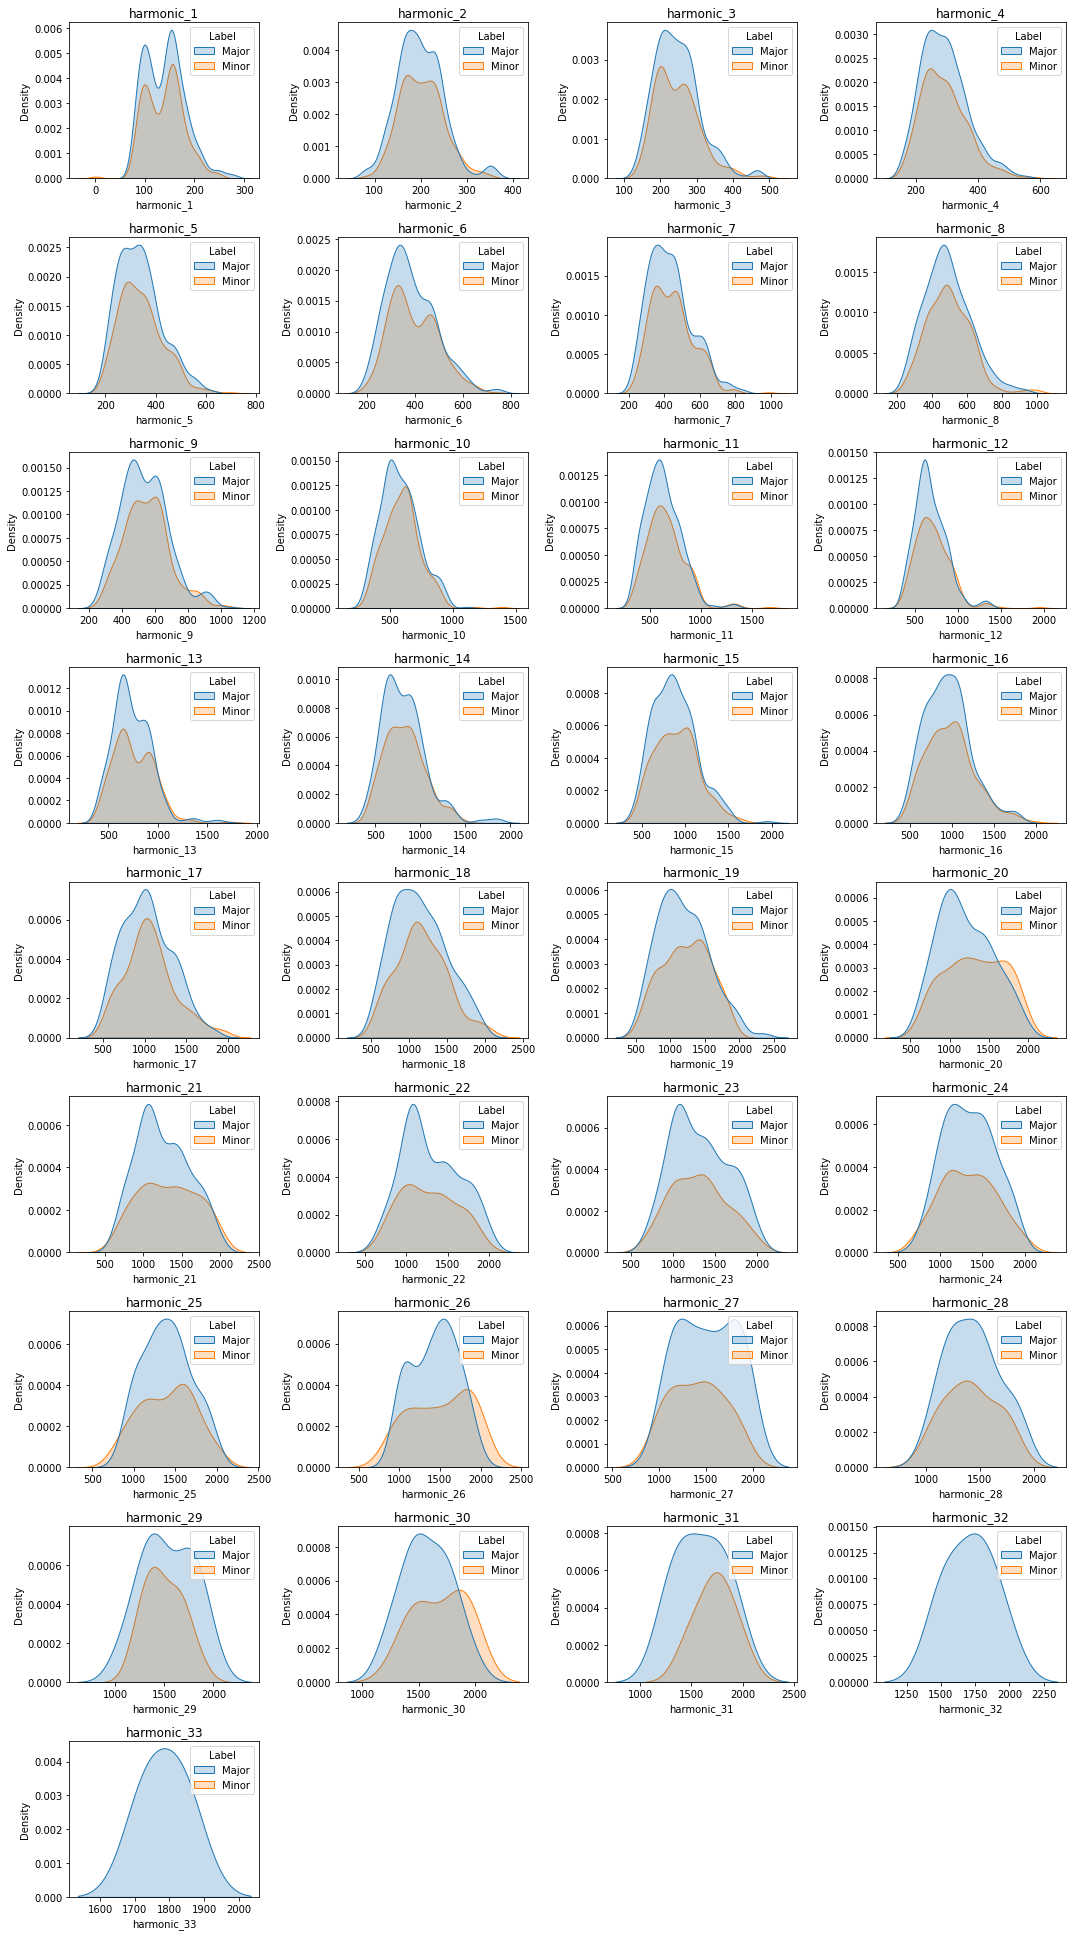

In [154]:
num_cols = 4
num_rows = int(np.ceil(len(harmonic_columns) / num_cols))

# Loop through each harmonic and plot the distributions
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()  # Flatten axes for easier iteration

for i, col in enumerate(harmonic_columns):
    sns.kdeplot(ax=axes[i], data=harmonics_df, x=col, hue="Label", fill=True)
    axes[i].set_title(col)

# Hide extra subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

<ipython-input-155-427c5e135554>:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[i], data=harmonics_df, x=col, hue="Label", fill=True)


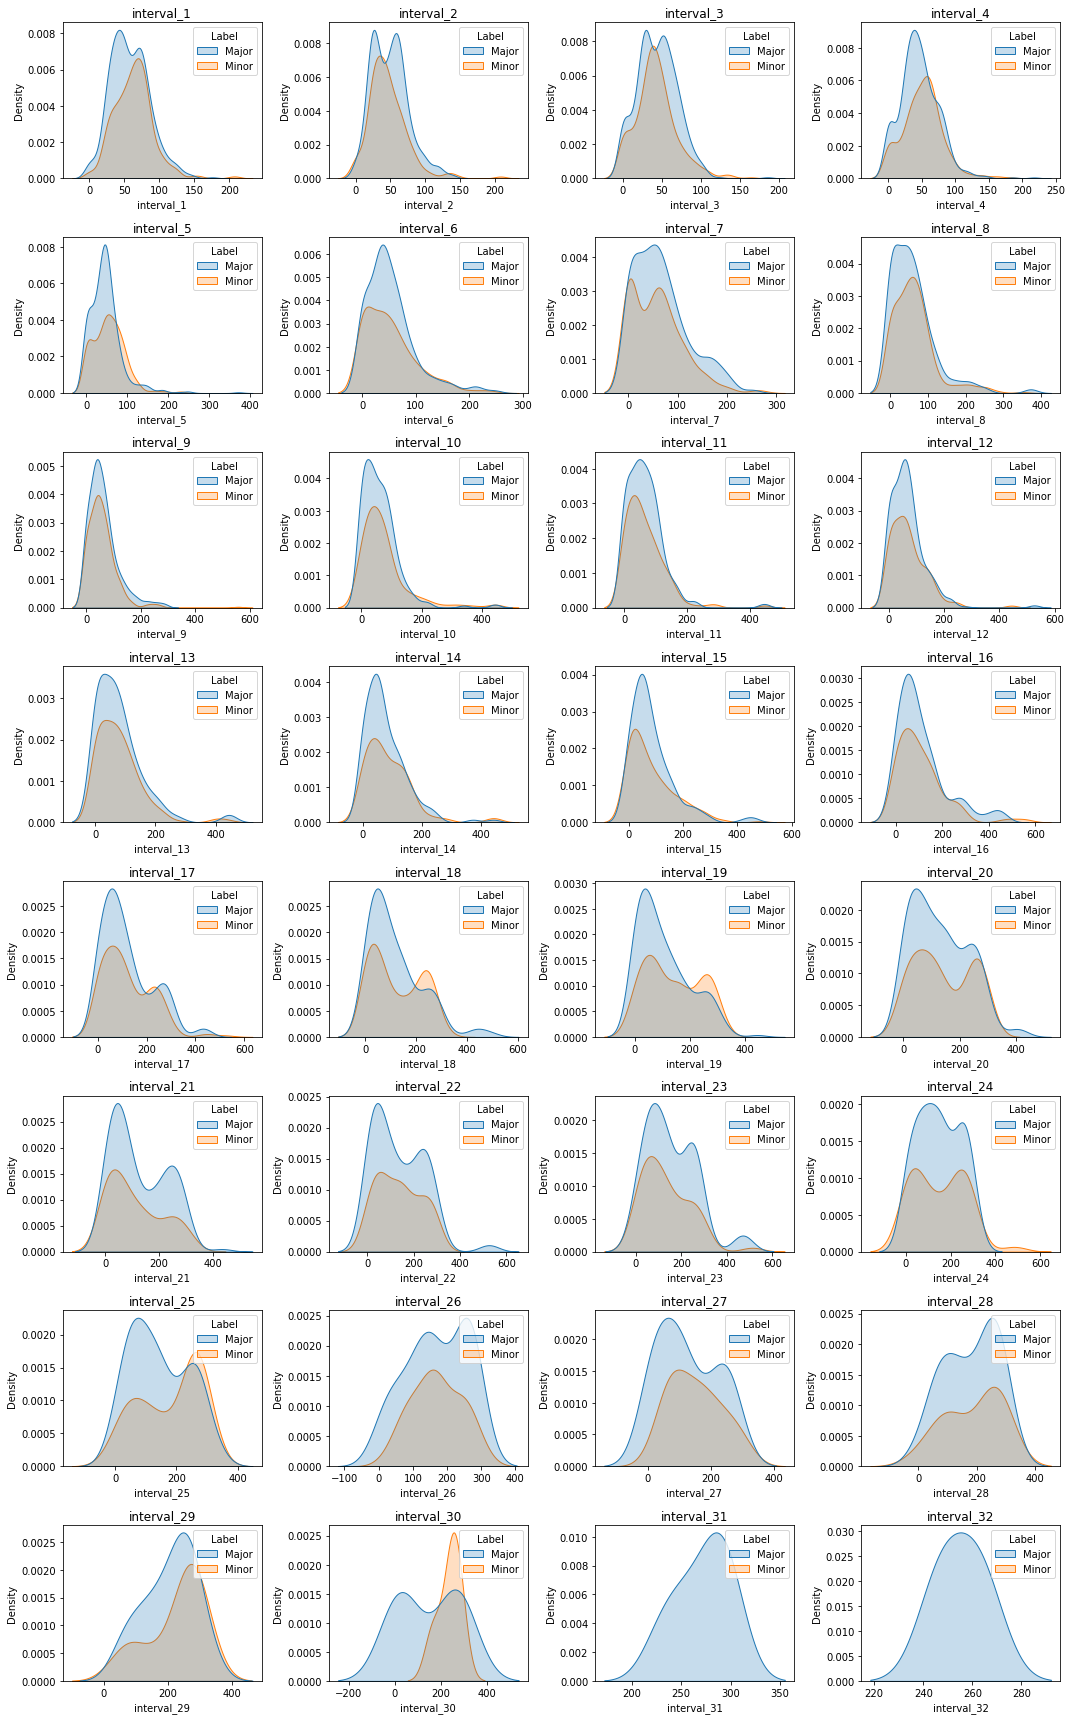

In [155]:
num_cols = 4
num_rows = int(np.ceil(len(interval_columns) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

for i, col in enumerate(interval_columns):
    sns.kdeplot(ax=axes[i], data=harmonics_df, x=col, hue="Label", fill=True)
    axes[i].set_title(col)

# Hide extra subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [156]:
# Programatic Correlation Analysis

correlations = harmonics_df[harmonic_columns + interval_columns].corrwith(harmonics_df['Label'].astype('category').cat.codes)

# Sort the correlations by absolute value to find the most important features
sorted_correlations = correlations.abs().sort_values(ascending=False)
print(sorted_correlations.head(10))  # Top 10 features

interval_30    0.376308
interval_31    0.371645
harmonic_31    0.288976
harmonic_30    0.263166
interval_19    0.175691
interval_25    0.175097
harmonic_27    0.166560
harmonic_20    0.166202
interval_27    0.135225
interval_29    0.113898
dtype: float64


#### Manual Inspection:

##### Harmonics:

Visually inspecting the plots for Harmonics and Intervals that might be more helpful in our model to distinguish chords, these are the harmonics with LESS overlay in Major / Minor chords (though, not by much!):

- harmonic_20
- harmonic_26
- harmonic_30

##### Intervals:
- interval_1
- interval_2
- interval_3
- interval_4
- interval_19
- interval_25
- interval_30

Other Notes:
- Interval 28 and 5 seem to have a similar shape, but different densities. Though, there is a small bit of non-overlap. This also applies for harmonic_26
- Interval 31 and 32 are both only charts with 'Major', meaning the 'Minor' data is either extremely small, or non-existant (likely the latter). I'm not sure whether we should use these quite yet. 

### Combined Analysis for Feature Engineering:

With our manual inspection and programatic correlation analysis, here is a final list of features:

- harmonic_20: Appears in both visual and correlation analysis.
- harmonic_26: Identified visually.
- harmonic_30: Strong in both visual and correlation analysis.
- harmonic_31: High correlation but not identified visually (worth testing).

##### Intervals:

- Interval 2, 3, 4, 19, 25: Visually identified
- Interval 30: Strong in both visual and correlation analysis.
- 
    Interval 27
    Interval 31: High correlation, but missing Minor data (requires further scrutiny).


In [184]:
selected_harmonic_features = [ 'id',
    'harmonic_20', 'harmonic_26', 'harmonic_30', 'harmonic_31',
    'interval_1', 'interval_2', 'interval_3', 'interval_4', 'interval_19', 
    'interval_25', 'interval_30', 'interval_27', 'interval_31'
]

---

# Modeling

This is a classification problem, with the goal of predicting whether a chord is major or minor. The initial plan is to use a basic model like logistic regression or SVM as a baseline. After extracting features like MFCCs or spectrograms, we will establish the baseline and then experiment with more advanced models like convolutional neural networks (CNNs) to improve accuracy.

### Data Prep before modeling:

Audio Features dataframe with selected harmonic features

features_df

In [207]:
# Impute NaNs for harmonic and interval features
harmonic_columns = selected_harmonic_features[1:]  # All except 'id'

imputer = SimpleImputer(strategy='mean')
harmonics_df[harmonic_columns] = imputer.fit_transform(harmonics_df[harmonic_columns])

# Combine harmonics_df and features_df
combined_df = pd.merge(harmonics_df[selected_harmonic_features], features_df, on='id', how='inner')

In [208]:
# Fix the 'Label_x' header
if 'Label_x' in combined_df.columns:
    combined_df = combined_df.rename(columns={'Label_x': 'Label'})

In [209]:
# Slice the DataFrame into X (features) and y (labels)
X = combined_df.drop(columns=['Label', 'id'])
y = combined_df['Label']

In [210]:
harmonics_df.loc[:, harmonic_columns] = harmonics_df[harmonic_columns].fillna(0)

# Combine feature extraction methods into one dataframe
combined_df = pd.merge(harmonics_df[selected_harmonic_features], features_df, on='id', how='inner')

# Fix the 'Label_x' header if necessary
if 'Label_x' in combined_df.columns:
    combined_df = combined_df.rename(columns={'Label_x': 'Label'})

# Display the first few rows of the combined dataframe to verify
print(combined_df.head())

          id  harmonic_20  harmonic_26  harmonic_30  harmonic_31  interval_1  \
0    Major_0   1158.21055          0.0          0.0          0.0   34.666317   
1    Major_1      0.00000          0.0          0.0          0.0   31.110798   
2   Major_10      0.00000          0.0          0.0          0.0   54.090909   
3  Major_100      0.00000          0.0          0.0          0.0   40.454545   
4  Major_101      0.00000          0.0          0.0          0.0   40.909091   

   interval_2  interval_3  interval_4  interval_19  ...   mfcc_13    mfcc_14  \
0   30.666358   66.221555   67.110435   108.443352  ... -1.233236   2.531613   
1   65.332675   67.999315    1.333320   119.078201  ... -5.643203  -4.957089   
2   49.090909   28.181818   67.272727   119.078201  ... -2.584889 -16.698959   
3   82.272727   33.181818   38.181818   119.078201  ... -7.823734  -6.011680   
4    0.909091   80.454545   33.181818   119.078201  ...  3.361689   0.215648   

     mfcc_15    mfcc_16    mfcc_17    

In [211]:
# Encode labels (Major/Minor) as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels for neural network
y_onehot = to_categorical(y_encoded)

In [212]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [213]:
# Scale the features (StandardScaler)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [214]:
# Build the DNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))  # Input layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(2, activation='softmax'))  # Output layer (2 classes: Major/Minor)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
18/18 [==============================] - 1s 7ms/step - loss: 0.7158 - accuracy: 0.5446 - val_loss: 0.6796 - val_accuracy: 0.5870
Epoch 2/30
18/18 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.5537 - val_loss: 0.6649 - val_accuracy: 0.6232
Epoch 3/30
18/18 [==============================] - 0s 2ms/step - loss: 0.6430 - accuracy: 0.6485 - val_loss: 0.6487 - val_accuracy: 0.6449
Epoch 4/30
18/18 [==============================] - 0s 2ms/step - loss: 0.6432 - accuracy: 0.6029 - val_loss: 0.6500 - val_accuracy: 0.6449
Epoch 5/30
18/18 [==============================] - 0s 2ms/step - loss: 0.6326 - accuracy: 0.6321 - val_loss: 0.6520 - val_accuracy: 0.6739
Epoch 6/30
18/18 [==============================] - 0s 2ms/step - loss: 0.6130 - accuracy: 0.6667 - val_loss: 0.6447 - val_accuracy: 0.6449
Epoch 7/30
18/18 [==============================] - 0s 2ms/step - loss: 0.6160 - accuracy: 0.6557 - val_loss: 0.6507 - val_accuracy: 0.6377
Epoch 8/30
18/18 [==

---

## Evaluation

To evaluate the model, we will use metrics such as accuracy, precision, recall, and F1-score, focusing on correctly classifying both major and minor chords. The minimum viable product (MVP) will involve building a baseline model (e.g., logistic regression or SVM) to classify the chords with reasonable accuracy. Stretch goals include improving the model using more complex techniques like CNNs or RNNs, and addressing any data imbalances to achieve better generalization and robustness.

In [215]:
# Model Predictions
y_pred = model.predict(X_test_scaled)  # Predict class probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to class labels

# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

6/6 [==============================] - 0s 803us/step
Classification Report:
              precision    recall  f1-score   support

       Major       0.71      0.82      0.76        98
       Minor       0.69      0.55      0.62        74

    accuracy                           0.70       172
   macro avg       0.70      0.69      0.69       172
weighted avg       0.70      0.70      0.70       172

Confusion Matrix:
[[80 18]
 [33 41]]


---

# Deployment

The results will be delivered through a simple Streamlit web app, where users can upload or record audio files to classify as major or minor chords. The app will provide real-time feedback, displaying the classification result along with confidence scores and visualizations such as waveforms or spectrograms. The app will be hosted on Streamlit Cloud, making it easily accessible and user-friendly for quick chord analysis.